# Dataset and Split

In [150]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier

data = load_iris()

X,Y = data.data, data.target

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2,stratify=Y ,random_state=42)

df_train = pd.concat([pd.DataFrame(x_train, columns=data.feature_names),pd.DataFrame(y_train, columns=['class'])],axis=1)
df_train

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,4.4,2.9,1.4,0.2,0
1,4.9,2.5,4.5,1.7,2
2,6.8,2.8,4.8,1.4,1
3,4.9,3.1,1.5,0.1,0
4,5.5,2.5,4.0,1.3,1
...,...,...,...,...,...
115,4.9,3.6,1.4,0.1,0
116,4.7,3.2,1.3,0.2,0
117,5.5,4.2,1.4,0.2,0
118,6.9,3.1,4.9,1.5,1


# Data vizualization

## Scatter Matrix

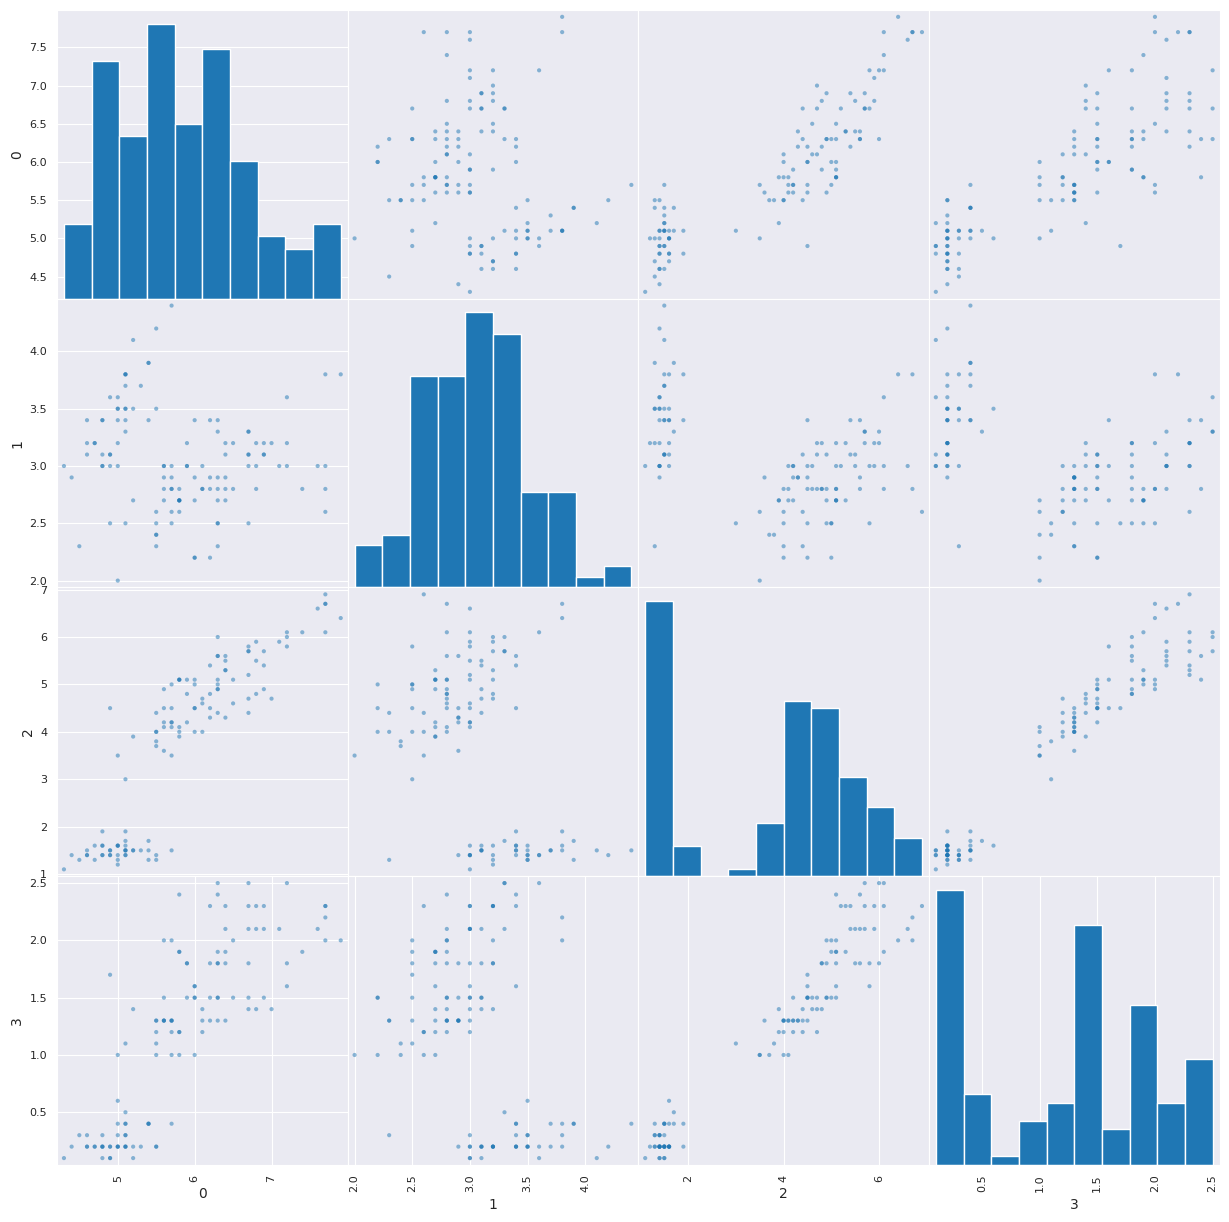

In [151]:
from pandas.plotting import scatter_matrix

df_x_train = pd.DataFrame(x_train)
scatter_matrix(df_x_train, figsize=(15,15))

plt.show()

## Correlation Matrix

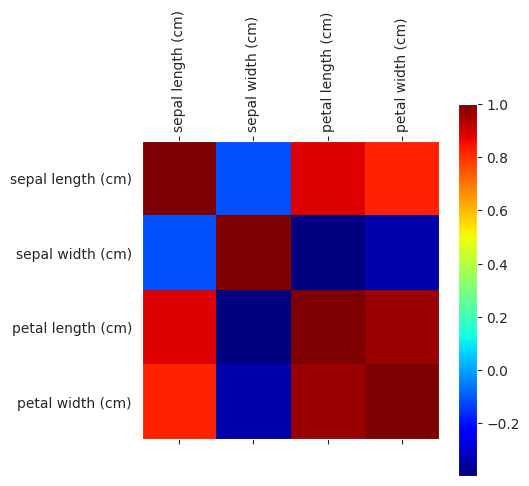

,0,1,2,3
0,1.000000,-0.112327,0.880401,0.820297
1,-0.112327,1.000000,-0.398502,-0.338741
2,0.880401,-0.398502,1.000000,0.963693
3,0.820297,-0.338741,0.963693,1.000000


In [152]:
names = data.feature_names
corr_mtx = (df_x_train).corr(method='pearson')
plt.matshow(corr_mtx, cmap="jet")
plt.colorbar()

plt.xticks(range(len(names)), names, rotation=90)
plt.yticks(range(len(names)), names)
plt.grid(False)
plt.show()

corr_mtx

# Metric function

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        40
           2       1.00      1.00      1.00        40

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120

roc_area_macro=1.0


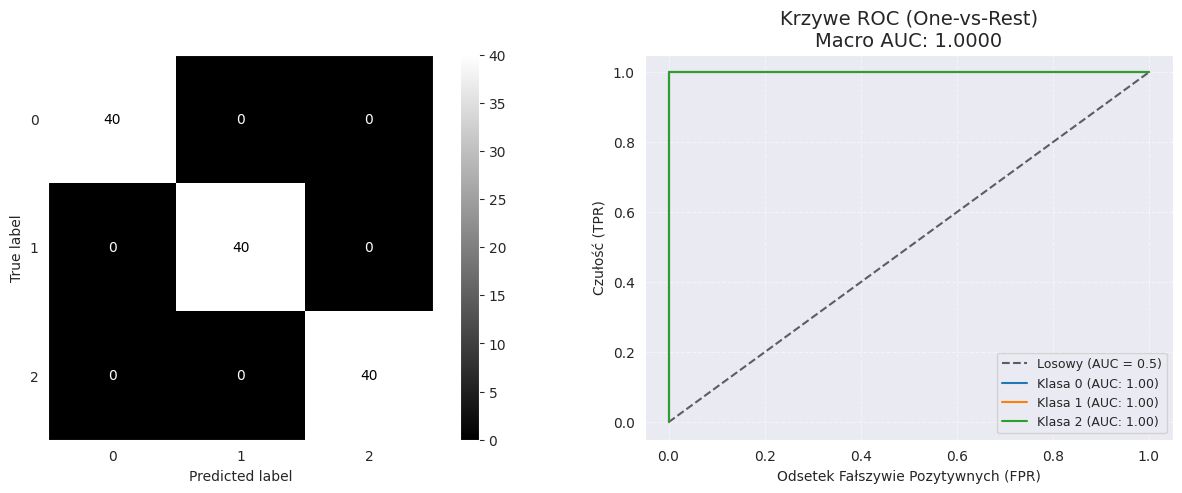

In [153]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize

def metric(preds, probs, true_labels):

    classes = np.unique(true_labels)
    true_labels_bin = label_binarize(true_labels, classes=classes)

    #Metrics
    cr = classification_report(true_labels, preds)
    cf_mtx = confusion_matrix(true_labels, preds)


    auc_scores = []
    for c in classes:
        auc_score = roc_auc_score(true_labels_bin[:, c], probs[:, c])
        auc_scores.append(auc_score)

    roc_area_macro = np.mean(auc_scores)

    #Ploting
    fig, (ax_cfmtx, ax_roc) = plt.subplots(1,2, figsize=(15,5))

    #Roc curves
    ax_roc.set_title(f'Krzywe ROC (One-vs-Rest)\nMacro AUC: {roc_area_macro:.4f}', fontsize=14)
    ax_roc.plot([0, 1], [0, 1], 'k--', label='Losowy (AUC = 0.5)', alpha=0.6)
    for c in classes:
        fpr, tpr, _ = roc_curve(true_labels_bin[:, c], probs[:, c])
        ax_roc.plot(fpr, tpr,label=f'Klasa {classes[c]} (AUC: {auc_scores[c]:.2f})')

    ax_roc.set_xlabel('Odsetek Fałszywie Pozytywnych (FPR)')
    ax_roc.set_ylabel('Czułość (TPR)')
    ax_roc.legend(loc="lower right", fontsize=9)
    ax_roc.grid(linestyle='--', alpha=0.5)

    #Confusion matrix
    ax_cfmtx.grid(False)
    ax_cfmtx = ConfusionMatrixDisplay(confusion_matrix=cf_mtx).plot(ax = ax_cfmtx, cmap="grey")

    print(cr)
    print(f'{roc_area_macro=}')

classes = np.unique(y_train)
metric(y_train, label_binarize(y_train, classes=classes), y_train)

# Optimize, train and judge

In [154]:
import optuna
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
import time

def selected_features(selector):
    global names

    mask = selector.get_support()
    selected_names = np.array(names)[mask]
    return list(selected_names)


def optimize_train_and_judge(title, scaler_class, model_class, objective_fn, trails=100):
    global x_train, y_train, x_test, y_test

    study = optuna.create_study(direction="maximize")

    start = time.time()
    study.optimize(objective_fn, n_trials=trails, show_progress_bar=True)
    stop = time.time()


    pipe = Pipeline([('scaler',scaler_class()),('features_selector', RFE(estimator=DecisionTreeClassifier())) ,('classifier', model_class())])
    pipe.set_params(**study.best_params)
    pipe.fit(x_train, y_train)

    ## Metrics
    preds = pipe.predict(x_test)
    probs = pipe.predict_proba(x_test)
    metric(preds, probs, y_test)

    selector = pipe.named_steps['features_selector']
    names_selected = selected_features(selector)
    features_shape = [x_test.shape[0], len(names_selected)]
    print(title)
    print(f"Selected features: {names_selected}")
    print(f"Optimize time: {stop-start}")

    return pipe

# Scalers

In [155]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

class RoubustMinMaxScaler(BaseEstimator):
    def __init__(self, q_r:tuple[int] = (25, 75)):
        self.q_r = q_r

    def fit(self, X, Y=None):

        [qa, qb] = np.quantile(X, q=self.q_r, axis=0)
        self.qa = qa
        self.qb = qb

        return self

    def transform(self, X):
        x_std = (X - self.qa) / (self.qb - self.qa)
        return x_std

## Standard Scaler and Logistic regression

In [156]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from typing import Literal


def ulitmate_objective_generator(scaler_name:Literal['standard', 'minmax', 'robust', 'robustMinMax'], model_name:Literal['Logistic', 'KNN']):

    scaler_class = None
    model_class = None

    if scaler_name == 'standard':
        scaler_class = StandardScaler

    elif scaler_name == 'minmax':
        scaler_class = MinMaxScaler

    elif scaler_name == 'robust':
        scaler_class = RobustScaler

    elif scaler_name == 'robustMinMax':
        scaler_class = RoubustMinMaxScaler

    if model_name == 'Logistic':
        model_class = LogisticRegression
    elif model_name == 'KNN':
        model_class = KNeighborsClassifier



    def objective(trial):
        #Scalers
        nonlocal scaler_class, model_class
        model_params = {}
        scaler_params = {}

        if scaler_class is StandardScaler:

            scaler_params = {}

        if scaler_class is MinMaxScaler:
            clip = trial.suggest_categorical('scaler__clip', [True, False])

            scaler_params = {'clip': clip}

        if scaler_class is RobustScaler:
            with_centering=trial.suggest_categorical('scaler__with_centering', [True, False])
            quantile_range = trial.suggest_categorical('scaler__quantile_range', [(0.1, 0.9), (0.25, 0.75), (0.3, 0.7), (0.4, 0.6)])

            scaler_params = {'with_scaling': True, 'with_centering': with_centering, 'quantile_range': quantile_range}

        if scaler_class is RoubustMinMaxScaler:
            q_r = trial.suggest_categorical('scaler__q_r', [(0.1, 0.9), (0.25, 0.75), (0.3, 0.7), (0.4, 0.6)])


            scaler_params = {'q_r': q_r}

        # Feature Selection
        n_features_to_select = trial.suggest_int('features_selector__n_features_to_select', 1, 4)


        # Models
        if model_class is LogisticRegression:
            C = trial.suggest_float('classifier__C', 1e-3, 1e2, log=True)
            solver = trial.suggest_categorical('classifier__solver', ['lbfgs', 'liblinear', 'saga'])
            max_iter = trial.suggest_int('classifier__max_iter', 100, 200)

            model_params = {'C': C, 'solver': solver, 'max_iter': max_iter}

        if model_class is KNeighborsClassifier:
            n_neighbors = trial.suggest_int("classifier__n_neighbors", 1, 80)
            weights = trial.suggest_categorical('classifier__weights', ['uniform', 'distance'])
            metric  = trial.suggest_categorical('classifier__metric', ['manhattan', 'euclidean','minkowski'])

            model_params = {'n_neighbors': n_neighbors, 'weights': weights, 'metric': metric}

        pipe = Pipeline([('scaler', scaler_class(**scaler_params)),('features_selector', RFE(estimator=DecisionTreeClassifier(), n_features_to_select=n_features_to_select)) ,
                     ('classifier', model_class(**model_params))])

        pipe.fit(x_train, y_train)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        score = cross_val_score(pipe, x_train, y_train, cv=cv, scoring= 'neg_mean_squared_error').mean()

        return score

    return [scaler_class, model_class, objective]

# Different Trials

In [157]:
import optuna
optuna.logging.disable_default_handler()

scalers = ['standard', 'minmax', 'robust', 'robustMinMax']
models = ['Logistic', 'KNN']

objectives = {}

for s in scalers:
    for m in models:
        objectives[f'{m} with {s} scaler'] = ulitmate_objective_generator(s, m)


objectives

{'Logistic with standard scaler': [sklearn.preprocessing._data.StandardScaler,
  sklearn.linear_model._logistic.LogisticRegression,
  <function __main__.ulitmate_objective_generator.<locals>.objective(trial)>],
 'KNN with standard scaler': [sklearn.preprocessing._data.StandardScaler,
  sklearn.neighbors._classification.KNeighborsClassifier,
  <function __main__.ulitmate_objective_generator.<locals>.objective(trial)>],
 'Logistic with minmax scaler': [sklearn.preprocessing._data.MinMaxScaler,
  sklearn.linear_model._logistic.LogisticRegression,
  <function __main__.ulitmate_objective_generator.<locals>.objective(trial)>],
 'KNN with minmax scaler': [sklearn.preprocessing._data.MinMaxScaler,
  sklearn.neighbors._classification.KNeighborsClassifier,
  <function __main__.ulitmate_objective_generator.<locals>.objective(trial)>],
 'Logistic with robust scaler': [sklearn.preprocessing._data.RobustScaler,
  sklearn.linear_model._logistic.LogisticRegression,
  <function __main__.ulitmate_object

# Train&Judge

  0%|          | 0/5 [00:00<?, ?it/s]

/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the 

[I 2025-12-02 12:45:30,038] Trial 0 finished with value: -0.03333333333333333 and parameters: {'features_selector__n_features_to_select': 4, 'classifier__C': 31.43769622039614, 'classifier__solver': 'saga', 'classifier__max_iter': 125}. Best is trial 0 with value: -0.03333333333333333.
[I 2025-12-02 12:45:30,078] Trial 1 finished with value: -0.03333333333333333 and parameters: {'features_selector__n_features_to_select': 3, 'classifier__C': 2.559756278634682, 'classifier__solver': 'lbfgs', 'classifier__max_iter': 171}. Best is trial 0 with value: -0.03333333333333333.
[I 2025-12-02 12:45:30,115] Trial 2 finished with value: -0.041666666666666664 and parameters: {'features_selector__n_features_to_select': 2, 'classifier__C': 0.14607999389350243, 'classifier__solver': 'lbfgs', 'classifier__max_iter': 147}. Best is trial 0 with value: -0.03333333333333333.
[I 2025-12-02 12:45:30,136] Trial 3 finished with value: -0.075 and parameters: {'features_selector__n_features_to_select': 3, 'classi

  0%|          | 0/5 [00:00<?, ?it/s]

[I 2025-12-02 12:45:30,256] Trial 0 finished with value: -0.041666666666666664 and parameters: {'features_selector__n_features_to_select': 2, 'classifier__n_neighbors': 71, 'classifier__weights': 'distance', 'classifier__metric': 'euclidean'}. Best is trial 0 with value: -0.041666666666666664.
[I 2025-12-02 12:45:30,302] Trial 1 finished with value: -0.09166666666666666 and parameters: {'features_selector__n_features_to_select': 3, 'classifier__n_neighbors': 38, 'classifier__weights': 'uniform', 'classifier__metric': 'minkowski'}. Best is trial 0 with value: -0.041666666666666664.
[I 2025-12-02 12:45:30,350] Trial 2 finished with value: -0.03333333333333333 and parameters: {'features_selector__n_features_to_select': 1, 'classifier__n_neighbors': 34, 'classifier__weights': 'distance', 'classifier__metric': 'minkowski'}. Best is trial 2 with value: -0.03333333333333333.
[I 2025-12-02 12:45:30,376] Trial 3 finished with value: -0.041666666666666664 and parameters: {'features_selector__n_f

[I 2025-12-02 12:45:30,466] A new study created in memory with name: no-name-66e8bec0-21b6-465d-97e0-d8361aa90867


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.82      0.90      0.86        10
           2       0.89      0.80      0.84        10

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30

roc_area_macro=0.9683333333333334
KNN with standard scaler
Selected features: ['petal length (cm)']
Optimize time: 0.20592641830444336


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2025-12-02 12:45:30,520] Trial 0 finished with value: -0.041666666666666664 and parameters: {'scaler__clip': False, 'features_selector__n_features_to_select': 1, 'classifier__C': 53.689098098167854, 'classifier__solver': 'saga', 'classifier__max_iter': 164}. Best is trial 0 with value: -0.041666666666666664.
[I 2025-12-02 12:45:30,553] Trial 1 finished with value: -0.13333333333333336 and parameters: {'scaler__clip': True, 'features_selector__n_features_to_select': 2, 'classifier__C': 2.925832525604916, 'classifier__solver': 'liblinear', 'classifier__max_iter': 102}. Best is trial 0 with value: -0.041666666666666664.
[I 2025-12-02 12:45:30,587] Trial 2 finished with value: -0.26666666666666666 and parameters: {'scaler__clip': True, 'features_selector__n_features_to_select': 2, 'classifier__C': 0.44132418405562407, 'classifier__solver': 'liblinear', 'classifier__max_iter': 150}. Best is trial 0 with value: -0.041666666666666664.
[I 2025-12-02 12:45:30,621] Trial 3 finished with value

[I 2025-12-02 12:45:30,729] A new study created in memory with name: no-name-d1c5f1ff-92e4-44c7-afd4-c5da182ae7c7


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30

roc_area_macro=0.98
Logistic with minmax scaler
Selected features: ['petal width (cm)']
Optimize time: 0.2097911834716797


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2025-12-02 12:45:30,778] Trial 0 finished with value: -0.3333333333333333 and parameters: {'scaler__clip': True, 'features_selector__n_features_to_select': 3, 'classifier__n_neighbors': 65, 'classifier__weights': 'uniform', 'classifier__metric': 'minkowski'}. Best is trial 0 with value: -0.3333333333333333.
[I 2025-12-02 12:45:30,840] Trial 1 finished with value: -0.041666666666666664 and parameters: {'scaler__clip': False, 'features_selector__n_features_to_select': 1, 'classifier__n_neighbors': 19, 'classifier__weights': 'distance', 'classifier__metric': 'minkowski'}. Best is trial 1 with value: -0.041666666666666664.
[I 2025-12-02 12:45:30,905] Trial 2 finished with value: -0.3333333333333333 and parameters: {'scaler__clip': False, 'features_selector__n_features_to_select': 2, 'classifier__n_neighbors': 71, 'classifier__weights': 'uniform', 'classifier__metric': 'euclidean'}. Best is trial 1 with value: -0.041666666666666664.
[I 2025-12-02 12:45:30,937] Trial 3 finished with value

[I 2025-12-02 12:45:31,051] A new study created in memory with name: no-name-06793574-4fd0-4c33-93cc-b8bfc06a4ad4


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.82      0.90      0.86        10
           2       0.89      0.80      0.84        10

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30

roc_area_macro=0.9700000000000001
KNN with minmax scaler
Selected features: ['petal length (cm)']
Optimize time: 0.24792909622192383


  0%|          | 0/5 [00:00<?, ?it/s]

/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0.1, 0.9) which is of type tuple.
  warnings.warn(message)
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0.25, 0.75) which is of type tuple.
  warnings.warn(message)
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0.3, 0.7) which is of type tuple.
  warnings.warn(message)
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distribution

[I 2025-12-02 12:45:31,098] Trial 0 finished with value: -0.05833333333333333 and parameters: {'scaler__with_centering': True, 'scaler__quantile_range': (0.1, 0.9), 'features_selector__n_features_to_select': 3, 'classifier__C': 17.08666866650928, 'classifier__solver': 'liblinear', 'classifier__max_iter': 100}. Best is trial 0 with value: -0.05833333333333333.


/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0.1, 0.9) which is of type tuple.
  warnings.warn(message)
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0.25, 0.75) which is of type tuple.
  warnings.warn(message)
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0.3, 0.7) which is of type tuple.
  warnings.warn(message)
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distribution

[I 2025-12-02 12:45:31,159] Trial 1 finished with value: -0.6083333333333333 and parameters: {'scaler__with_centering': False, 'scaler__quantile_range': (0.25, 0.75), 'features_selector__n_features_to_select': 2, 'classifier__C': 1.0680411298036039, 'classifier__solver': 'saga', 'classifier__max_iter': 177}. Best is trial 0 with value: -0.05833333333333333.
[I 2025-12-02 12:45:31,198] Trial 2 finished with value: -1.1916666666666669 and parameters: {'scaler__with_centering': False, 'scaler__quantile_range': (0.4, 0.6), 'features_selector__n_features_to_select': 1, 'classifier__C': 0.008721243326322443, 'classifier__solver': 'liblinear', 'classifier__max_iter': 179}. Best is trial 0 with value: -0.05833333333333333.
[I 2025-12-02 12:45:31,248] Trial 3 finished with value: -0.125 and parameters: {'scaler__with_centering': True, 'scaler__quantile_range': (0.3, 0.7), 'features_selector__n_features_to_select': 2, 'classifier__C': 20.451588540171123, 'classifier__solver': 'saga', 'classifier

/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0.1, 0.9) which is of type tuple.
  warnings.warn(message)
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0.25, 0.75) which is of type tuple.
  warnings.warn(message)
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0.3, 0.7) which is of type tuple.
  warnings.warn(message)
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distribution

[I 2025-12-02 12:45:31,343] Trial 4 finished with value: -0.041666666666666664 and parameters: {'scaler__with_centering': True, 'scaler__quantile_range': (0.4, 0.6), 'features_selector__n_features_to_select': 1, 'classifier__C': 53.93016345378349, 'classifier__solver': 'lbfgs', 'classifier__max_iter': 182}. Best is trial 4 with value: -0.041666666666666664.


[I 2025-12-02 12:45:31,427] A new study created in memory with name: no-name-b315fc2f-834f-4ff1-a850-b6e3157eac9e


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30

roc_area_macro=0.9833333333333334
Logistic with robust scaler
Selected features: ['petal width (cm)']
Optimize time: 0.29399776458740234


  0%|          | 0/5 [00:00<?, ?it/s]

/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0.1, 0.9) which is of type tuple.
  warnings.warn(message)
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0.25, 0.75) which is of type tuple.
  warnings.warn(message)
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0.3, 0.7) which is of type tuple.
  warnings.warn(message)
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distribution

[I 2025-12-02 12:45:31,532] Trial 0 finished with value: -0.049999999999999996 and parameters: {'scaler__with_centering': True, 'scaler__quantile_range': (0.4, 0.6), 'features_selector__n_features_to_select': 2, 'classifier__n_neighbors': 51, 'classifier__weights': 'uniform', 'classifier__metric': 'euclidean'}. Best is trial 0 with value: -0.049999999999999996.


/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0.1, 0.9) which is of type tuple.
  warnings.warn(message)
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0.25, 0.75) which is of type tuple.
  warnings.warn(message)
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0.3, 0.7) which is of type tuple.
  warnings.warn(message)
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distribution

[I 2025-12-02 12:45:31,642] Trial 1 finished with value: -0.03333333333333333 and parameters: {'scaler__with_centering': True, 'scaler__quantile_range': (0.1, 0.9), 'features_selector__n_features_to_select': 1, 'classifier__n_neighbors': 9, 'classifier__weights': 'uniform', 'classifier__metric': 'euclidean'}. Best is trial 1 with value: -0.03333333333333333.
[I 2025-12-02 12:45:31,677] Trial 2 finished with value: -0.05833333333333333 and parameters: {'scaler__with_centering': False, 'scaler__quantile_range': (0.3, 0.7), 'features_selector__n_features_to_select': 4, 'classifier__n_neighbors': 18, 'classifier__weights': 'distance', 'classifier__metric': 'manhattan'}. Best is trial 1 with value: -0.03333333333333333.


/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0.1, 0.9) which is of type tuple.
  warnings.warn(message)
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0.25, 0.75) which is of type tuple.
  warnings.warn(message)
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0.3, 0.7) which is of type tuple.
  warnings.warn(message)
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distribution

[I 2025-12-02 12:45:31,840] Trial 3 finished with value: -0.05833333333333333 and parameters: {'scaler__with_centering': True, 'scaler__quantile_range': (0.25, 0.75), 'features_selector__n_features_to_select': 2, 'classifier__n_neighbors': 62, 'classifier__weights': 'distance', 'classifier__metric': 'euclidean'}. Best is trial 1 with value: -0.03333333333333333.


/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0.1, 0.9) which is of type tuple.
  warnings.warn(message)
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0.25, 0.75) which is of type tuple.
  warnings.warn(message)
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0.3, 0.7) which is of type tuple.
  warnings.warn(message)
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distribution

[I 2025-12-02 12:45:31,905] Trial 4 finished with value: -0.025 and parameters: {'scaler__with_centering': False, 'scaler__quantile_range': (0.3, 0.7), 'features_selector__n_features_to_select': 2, 'classifier__n_neighbors': 6, 'classifier__weights': 'uniform', 'classifier__metric': 'euclidean'}. Best is trial 4 with value: -0.025.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.82      0.90      0.86        10
           2       0.89      0.80      0.84        10

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30

roc_area_macro=0.9916666666666667
KNN with robust scaler
Selected features: ['petal length (cm)', 'petal width (cm)']
Optimize time: 0.4783763885498047


  0%|          | 0/5 [00:00<?, ?it/s]

/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0.1, 0.9) which is of type tuple.
  warnings.warn(message)
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0.25, 0.75) which is of type tuple.
  warnings.warn(message)
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0.3, 0.7) which is of type tuple.
  warnings.warn(message)
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distribution

[I 2025-12-02 12:45:31,995] Trial 0 finished with value: -0.18333333333333335 and parameters: {'scaler__q_r': (0.3, 0.7), 'features_selector__n_features_to_select': 4, 'classifier__C': 0.002904752972962294, 'classifier__solver': 'saga', 'classifier__max_iter': 186}. Best is trial 0 with value: -0.18333333333333335.


/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0.1, 0.9) which is of type tuple.
  warnings.warn(message)
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0.25, 0.75) which is of type tuple.
  warnings.warn(message)
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0.3, 0.7) which is of type tuple.
  warnings.warn(message)
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distribution

[I 2025-12-02 12:45:32,045] Trial 1 finished with value: -0.19166666666666668 and parameters: {'scaler__q_r': (0.3, 0.7), 'features_selector__n_features_to_select': 3, 'classifier__C': 0.005376420993473129, 'classifier__solver': 'lbfgs', 'classifier__max_iter': 180}. Best is trial 0 with value: -0.18333333333333335.
[I 2025-12-02 12:45:32,079] Trial 2 finished with value: -0.2916666666666667 and parameters: {'scaler__q_r': (0.3, 0.7), 'features_selector__n_features_to_select': 2, 'classifier__C': 0.17252335570044147, 'classifier__solver': 'liblinear', 'classifier__max_iter': 152}. Best is trial 0 with value: -0.18333333333333335.


/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0.1, 0.9) which is of type tuple.
  warnings.warn(message)
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0.25, 0.75) which is of type tuple.
  warnings.warn(message)
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0.3, 0.7) which is of type tuple.
  warnings.warn(message)
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distribution

[I 2025-12-02 12:45:32,119] Trial 3 finished with value: -0.15000000000000002 and parameters: {'scaler__q_r': (0.25, 0.75), 'features_selector__n_features_to_select': 3, 'classifier__C': 0.01555612165427877, 'classifier__solver': 'lbfgs', 'classifier__max_iter': 143}. Best is trial 3 with value: -0.15000000000000002.
[I 2025-12-02 12:45:32,147] Trial 4 finished with value: -0.27499999999999997 and parameters: {'scaler__q_r': (0.1, 0.9), 'features_selector__n_features_to_select': 3, 'classifier__C': 0.10325117238965609, 'classifier__solver': 'liblinear', 'classifier__max_iter': 144}. Best is trial 3 with value: -0.15000000000000002.


[I 2025-12-02 12:45:32,210] A new study created in memory with name: no-name-560b52fa-5793-4940-8190-ca9c93d71408


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.80      0.40      0.53        10
           2       0.60      0.90      0.72        10

    accuracy                           0.77        30
   macro avg       0.80      0.77      0.75        30
weighted avg       0.80      0.77      0.75        30

roc_area_macro=0.9416666666666668
Logistic with robustMinMax scaler
Selected features: ['sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Optimize time: 0.1858220100402832


  0%|          | 0/5 [00:00<?, ?it/s]

/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0.1, 0.9) which is of type tuple.
  warnings.warn(message)
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0.25, 0.75) which is of type tuple.
  warnings.warn(message)
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0.3, 0.7) which is of type tuple.
  warnings.warn(message)
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distribution

[I 2025-12-02 12:45:32,261] Trial 0 finished with value: -0.25000000000000006 and parameters: {'scaler__q_r': (0.1, 0.9), 'features_selector__n_features_to_select': 4, 'classifier__n_neighbors': 67, 'classifier__weights': 'uniform', 'classifier__metric': 'manhattan'}. Best is trial 0 with value: -0.25000000000000006.
[I 2025-12-02 12:45:32,310] Trial 1 finished with value: -0.041666666666666664 and parameters: {'scaler__q_r': (0.1, 0.9), 'features_selector__n_features_to_select': 2, 'classifier__n_neighbors': 25, 'classifier__weights': 'uniform', 'classifier__metric': 'manhattan'}. Best is trial 1 with value: -0.041666666666666664.


/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0.1, 0.9) which is of type tuple.
  warnings.warn(message)
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0.25, 0.75) which is of type tuple.
  warnings.warn(message)
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0.3, 0.7) which is of type tuple.
  warnings.warn(message)
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distribution

[I 2025-12-02 12:45:32,346] Trial 2 finished with value: -0.041666666666666664 and parameters: {'scaler__q_r': (0.4, 0.6), 'features_selector__n_features_to_select': 3, 'classifier__n_neighbors': 28, 'classifier__weights': 'distance', 'classifier__metric': 'euclidean'}. Best is trial 1 with value: -0.041666666666666664.
[I 2025-12-02 12:45:32,370] Trial 3 finished with value: -0.041666666666666664 and parameters: {'scaler__q_r': (0.1, 0.9), 'features_selector__n_features_to_select': 4, 'classifier__n_neighbors': 21, 'classifier__weights': 'distance', 'classifier__metric': 'manhattan'}. Best is trial 1 with value: -0.041666666666666664.


/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0.1, 0.9) which is of type tuple.
  warnings.warn(message)
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0.25, 0.75) which is of type tuple.
  warnings.warn(message)
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0.3, 0.7) which is of type tuple.
  warnings.warn(message)
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/optuna/distribution

[I 2025-12-02 12:45:32,434] Trial 4 finished with value: -0.041666666666666664 and parameters: {'scaler__q_r': (0.25, 0.75), 'features_selector__n_features_to_select': 2, 'classifier__n_neighbors': 41, 'classifier__weights': 'uniform', 'classifier__metric': 'euclidean'}. Best is trial 1 with value: -0.041666666666666664.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30

roc_area_macro=0.995
KNN with robustMinMax scaler
Selected features: ['petal length (cm)', 'petal width (cm)']
Optimize time: 0.22589731216430664


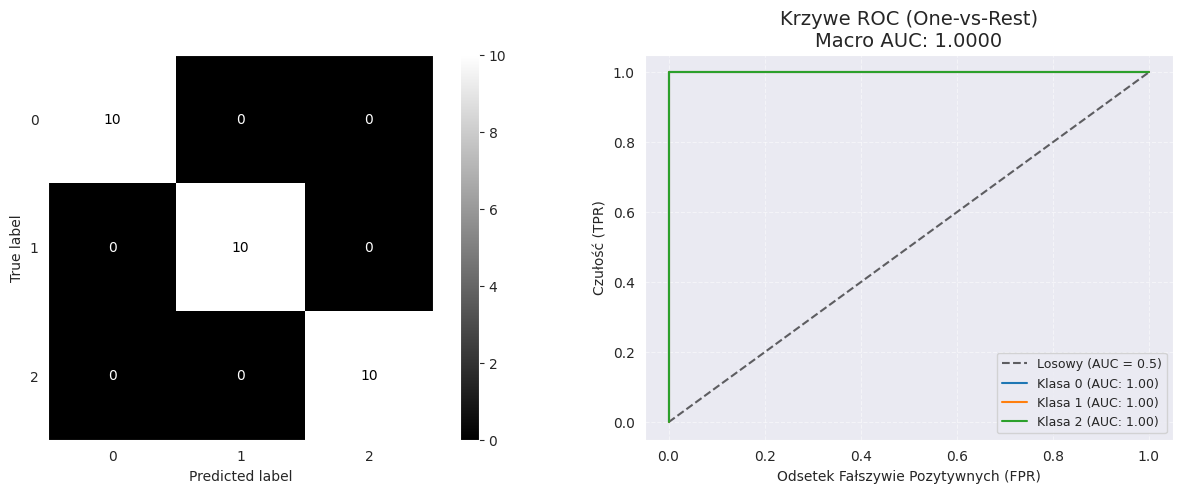

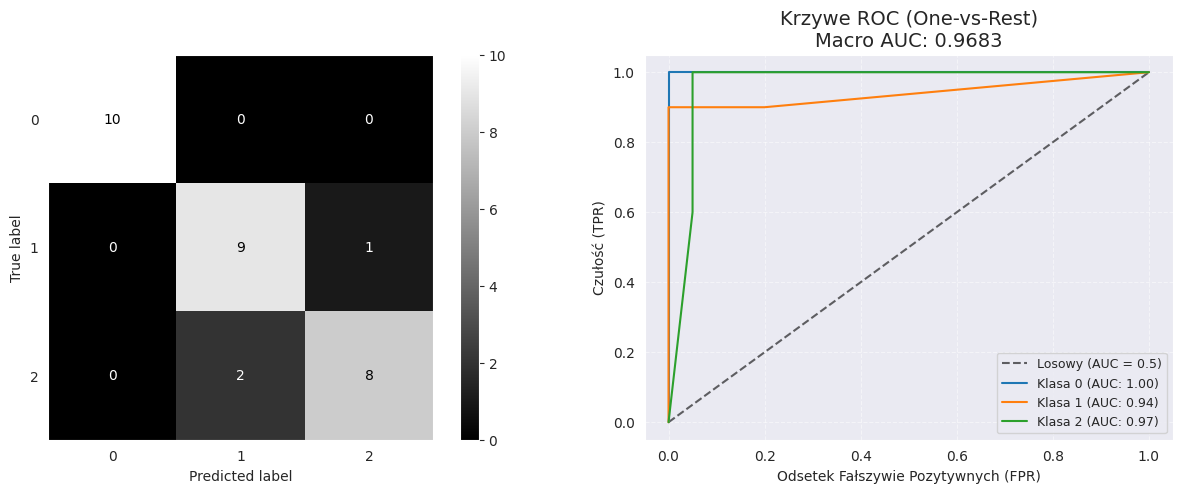

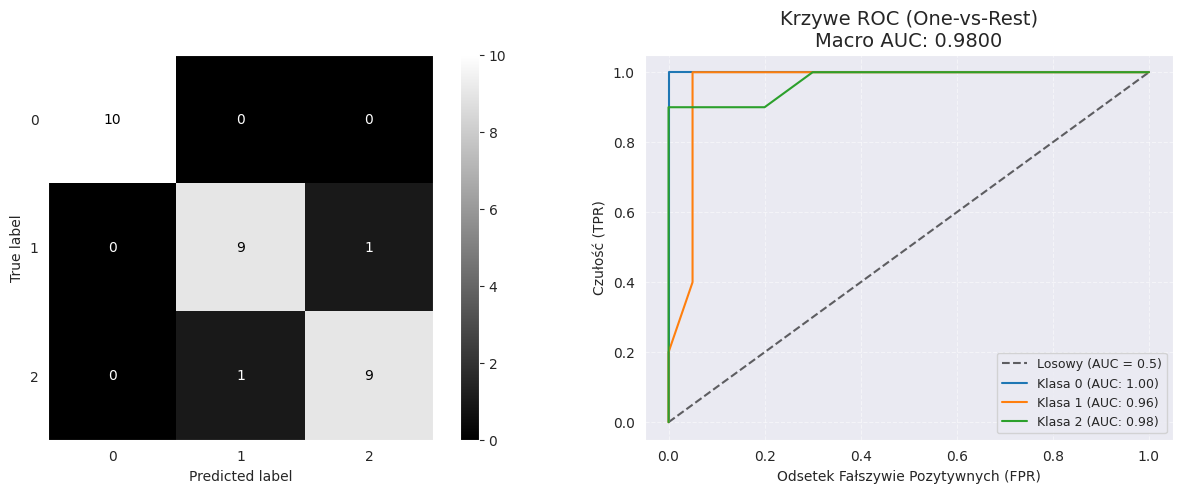

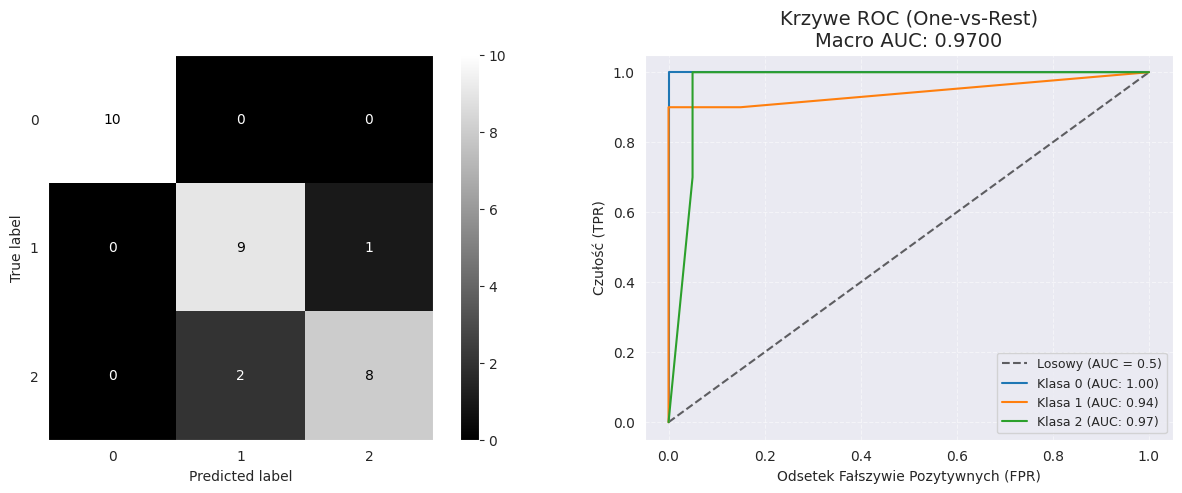

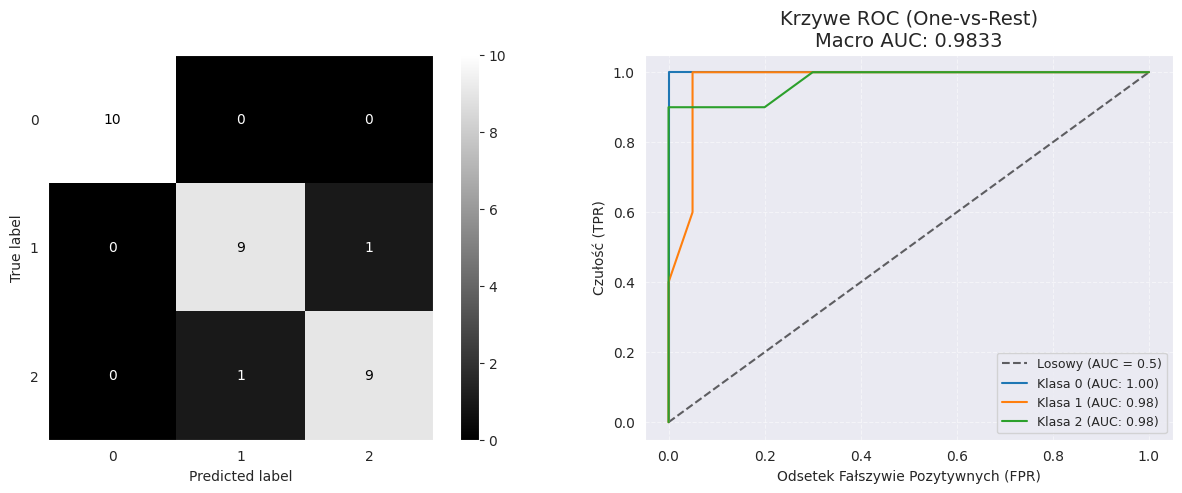

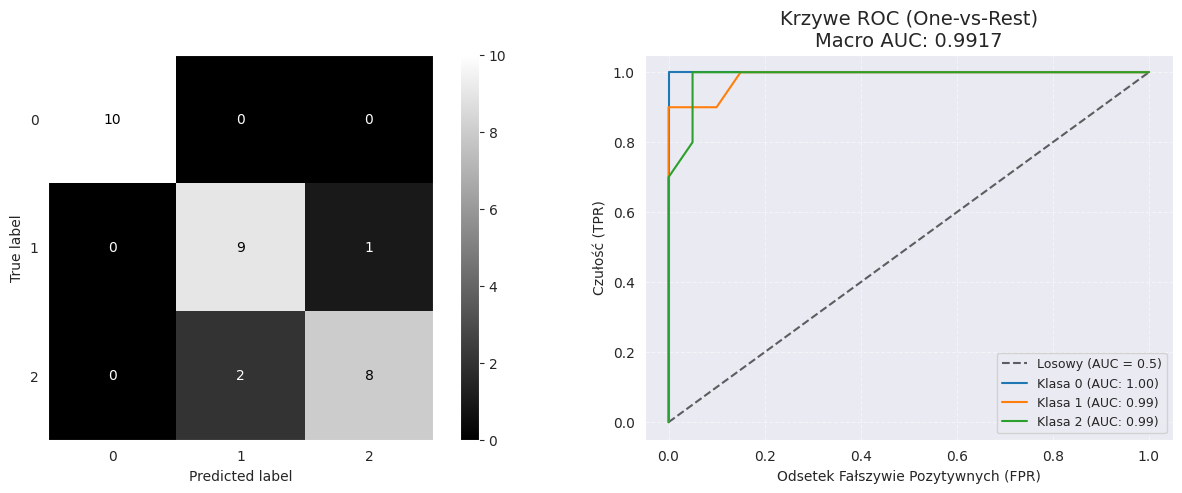

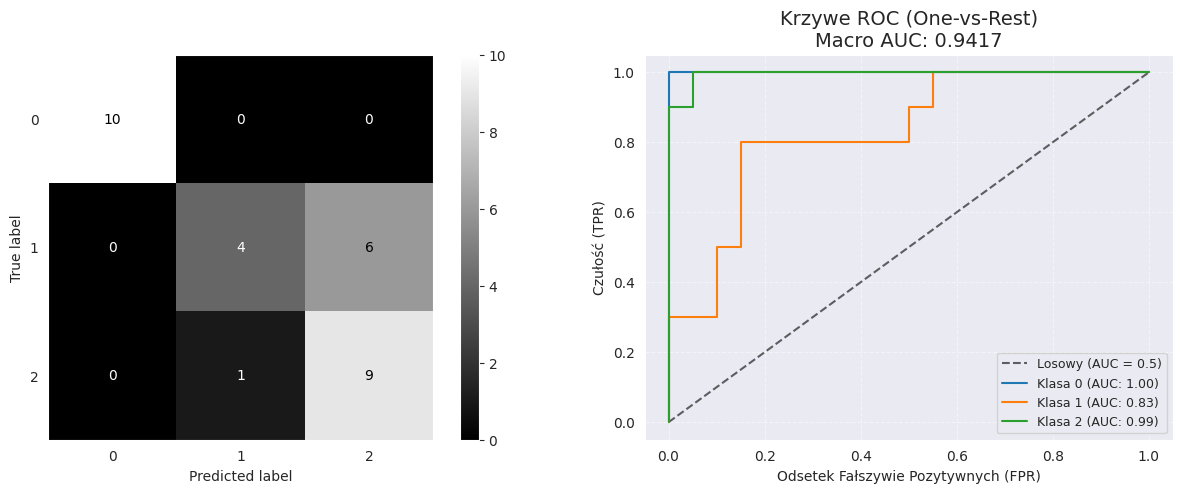

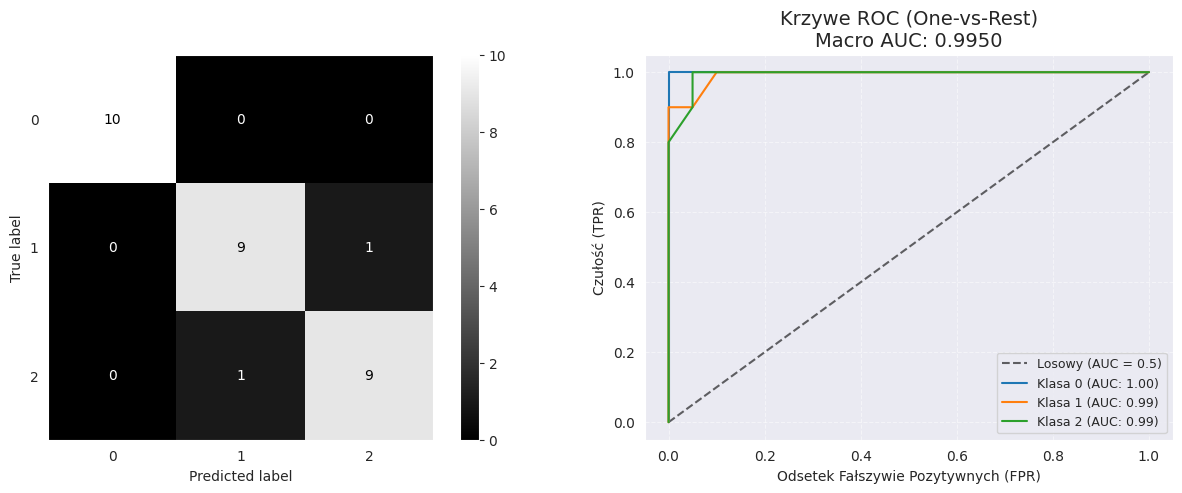

In [158]:
for name in objectives.keys():
    optimize_train_and_judge(title=name, scaler_class=objectives[name][0], model_class=objectives[name][1], objective_fn=objectives[name][2], trails=5)
